In [1]:
# Model Parameters

BATCH_SIZE = 32
GAUSSIAN_NOISE = 0.1
UPSAMPLING_MODE = 'Simple'

VALIDATION_SET_SIZE = 400
EPOCHS = 200

In [24]:
import os
import gc
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from skimage.io import imread
from skimage.morphology import label
from skimage.util import montage2d as montage
from skimage.segmentation import mark_boundaries

gc.enable()

In [36]:
montage_rgb = lambda x: np.stack([montage(x[:, :, :, i]) for i in range(x.shape[3])], -1)
input_dir = ''

train_image_dir = os.path.join(input_dir, 'train')
test_image_dir = os.path.join(input_dir, 'test')

In [27]:
def rle_encode(img):
    '''
    img: numpy array, 1 - mask, 0 - background
    Returns run length as string formated
    '''
    pixels = img.T.flatten()
    pixels = np.concatenate([[0], pixels, [0]])
    runs = np.where(pixels[1:] != pixels[:-1])[0] + 1
    runs[1::2] -= runs[::2]
    return ' '.join(str(x) for x in runs)


def rle_decode(mask_rle, shape=(768, 768)):
    '''
    mask_rle: run-length as string formated (start length)
    shape: (height,width) of array to return 
    Returns numpy array, 1 - mask, 0 - background
    '''
    s = mask_rle.split()
    starts, lengths = [np.asarray(x, dtype=int) for x in (s[0:][::2], s[1:][::2])]
    starts -= 1
    ends = starts + lengths
    img = np.zeros(shape[0] * shape[1], dtype=np.uint8)
    for lo, hi in zip(starts, ends):
        img[lo:hi] = 1
    return img.reshape(shape).T


def multi_rle_encode(img):
    labels = label(img[:, :, 0])
    return [rle_encode(labels == k) for k in np.unique(labels[labels>0])]

def masks_as_image(in_mask_list):
    # Take the individual ship masks and create a single mask array for all ships
    all_masks = np.zeros((768, 768), dtype = np.int16)
    #if isinstance(in_mask_list, list):
    for mask in in_mask_list:
        if isinstance(mask, str):
            all_masks += rle_decode(mask)
    return np.expand_dims(all_masks, -1)

In [14]:
masks = pd.read_csv(os.path.join('train_ship_segmentations.csv'))
print(masks.shape[0], 'mask found')
print(masks['ImageId'].value_counts().shape[0])
masks.head()

131030 mask found
104070


,ImageId,EncodedPixels
0,00003e153.jpg,NaN
1,000155de5.jpg,264661 17 265429 33 266197 33 266965 33 267733...
2,00021ddc3.jpg,101361 1 102128 3 102896 4 103663 6 104430 9 1...
3,00021ddc3.jpg,95225 2 95992 5 96760 7 97527 9 98294 9 99062 ...
4,00021ddc3.jpg,74444 4 75212 4 75980 4 76748 4 77517 3 78285 ...


Check Decoding->Encoding RLE_0: 9 -> RLE_1: 4


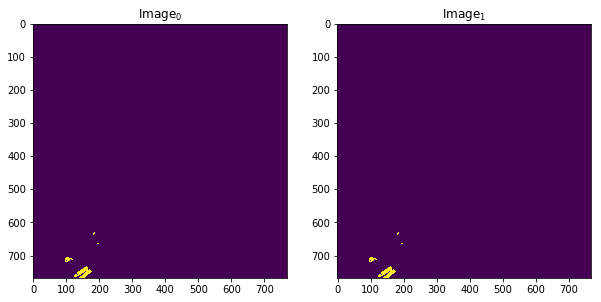

In [29]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))
rle_0 = masks.query('ImageId=="00021ddc3.jpg"')['EncodedPixels']
img_0 = masks_as_image(rle_0)

ax1.imshow(img_0[:, :, 0])
ax1.set_title('Image$_0$')

rle_1 = multi_rle_encode(img_0)
img_1 = masks_as_image(rle_1)

ax2.imshow(img_1[:, :, 0])
ax2.set_title('Image$_1$')
print('Check Decoding->Encoding',
      'RLE_0:', len(rle_0), '->',
      'RLE_1:', len(rle_1))

,ImageId,ships,has_ship,has_ship_vec,file_size_in_kb
1194,02cbeb068.jpg,0,0.0,[0.0],94.389648
8824,1564df576.jpg,0,0.0,[0.0],129.943359
45978,7103690a2.jpg,0,0.0,[0.0],193.994141
34842,55d8a645b.jpg,2,1.0,[1.0],57.990234
26092,403b32cf7.jpg,1,1.0,[1.0],294.427734


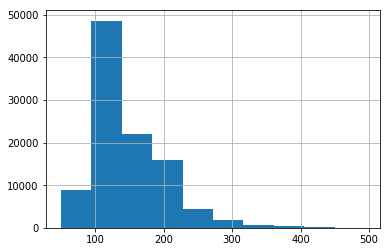

In [37]:
# Spliting into training and validation sets

masks['ships'] = masks['EncodedPixels'].map(lambda c_row: 1 if isinstance(c_row, str) else 0)
unique_img_ids = masks.groupby('ImageId').agg({'ships': 'sum'}).reset_index()
unique_img_ids['has_ship'] = unique_img_ids['ships'].map(lambda x: 1.0 if x > 0 else 0.0)
unique_img_ids['has_ship_vec'] = unique_img_ids['has_ship'].map(lambda x: [x])

# some files are too small/corrupt
unique_img_ids['file_size_in_kb'] = unique_img_ids['ImageId'].map(lambda c_img_id: os.stat(os.path.join(train_image_dir, c_img_id)).st_size/1024)
unique_img_ids = unique_img_ids[unique_img_ids['file_size_in_kb']>50]
unique_img_ids['file_size_in_kb'].hist()

masks.drop(['ships'], axis=1, inplace=True)
unique_img_ids.sample(5)

In [41]:
from sklearn.model_selection import train_test_split
train_ids, validation_ids = train_test_split(unique_img_ids, test_size=0.3,
                                            stratify=unique_img_ids['ships'])

train_df = pd.merge(masks, train_ids)
validation_df = pd.merge(masks, validation_ids)

print('Training masks', train_df.shape[0])
print('Validation masks', validation_df.shape[0])

Training masks 91008
Validation masks 39006


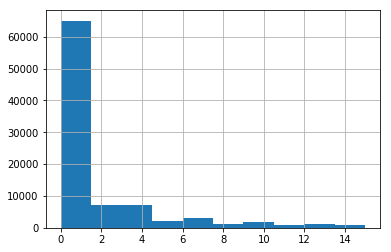

In [42]:
train_df['ships'].hist()

array([ 0,  1,  2,  4,  3,  5,  6,  8,  7,  9, 10, 11, 12, 15, 13, 14])

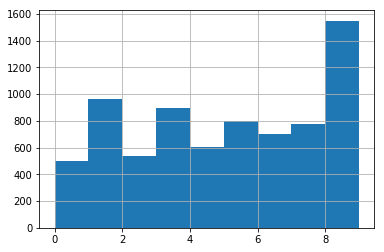

In [49]:
# undersample the data set

def sample_ships(in_df, base_rep=1500):
    if in_df['ships'].values[0] == 0:
        return in_df.sample(base_rep//3)
    else:
        return in_df.sample(base_rep, replace=(in_df.shape[0] < base_rep))

train_df['grouped_ship_count'] = train_df['ships'].map(lambda x: (x + 1)//2).clip(0, 7)

balanced_train_df = train_df.groupby('grouped_ship_count').apply(sample_ships)
balanced_train_df['ships'].hist(bins=np.arange(10))
balanced_train_df.ships.unique()
